<a href="https://colab.research.google.com/github/LuisCGit/6.484-reinforcement-learning/blob/main/uncertainty_aware_baseline_on_frozen_lake_(probability_%2B_exploration).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spring 2022 6.484 Computational Sensorimotor Learning Assignment 2

In this assignment, we will implement model-free RL algorithms from scratch to solve `DoorKeyEnv5x5`.  We will cover:


* REINFORCE
* Vanilla Policy Gradient (VPG)
* Generalized Advantage Estimation (GAE)
* Proximal Policy Optimization (PPO)

You will need to **answer the bolded questions** and **fill in the missing code snippets** (marked by **TODO**).

There are (approximately) **150** total points to be had in this PSET.  `ctrl-f` for "pts" to ensure you don't miss questions.

**_Please fill in your name below:_**

**Name**: Luis Costa Laveron

## Setup

The following code sets up requirements, imports, and helper functions (you can ignore this).

In [18]:
!pip install gym-minigrid &>/dev/null
# !pip install gym-minigrid > /dev/null 2>&1

In [19]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import torch.nn.functional as F
import gym_minigrid
import numpy as np
import matplotlib.pyplot as plt
import gym
from tqdm.notebook import tqdm
from gym_minigrid.envs.doorkey import DoorKeyEnv
import pandas as pd
import itertools
import random
import seaborn as sns
import math

%matplotlib inline
import numpy as np
import time
import json
import matplotlib as mpl


from copy import deepcopy
from dataclasses import dataclass
from matplotlib import animation
from IPython.display import HTML
from typing import Any
from collections import deque

mpl.rcParams['figure.dpi']= 100

In [4]:
# some util functions
def plot(logs, x_key, y_key, legend_key, **kwargs):
    nums = len(logs[legend_key].unique())
    palette = sns.color_palette("hls", nums)
    if 'palette' not in kwargs:
        kwargs['palette'] = palette
    sns.lineplot(x=x_key, y=y_key, data=logs, hue=legend_key, **kwargs)

def set_random_seed(seed):
    np.random.seed(seed)
    random.seed(seed)

# set random seed
seed = 0
set_random_seed(seed=seed)

In [20]:
# Function from https://github.com/ikostrikov/pytorch-a2c-ppo-acktr/blob/master/model.py
def init_params(m):
    classname = m.__class__.__name__
    if classname.find("Linear") != -1:
        m.weight.data.normal_(0, 1)
        m.weight.data *= 1 / torch.sqrt(m.weight.data.pow(2).sum(1, keepdim=True))
        if m.bias is not None:
            m.bias.data.fill_(0)

def preprocess_obss(obss, device=None):
    if isinstance(obss, dict):
        images = np.array([obss["image"]])
    else:
        images = np.array([o["image"] for o in obss])
    
    return torch.tensor(images, device=device, dtype=torch.float)

class DoorKeyEnv5x5(DoorKeyEnv):
    def __init__(self):
        super().__init__(size=5)
    
    def _reward(self):
        """
        Compute the reward to be given upon success
        """
        return 1

In [6]:
## create FrozenLake environment
MAPS = {
    "4x4": [
        "GHFS",
        "FHHF",
        "FFHF",
        "FFFF"
    ],
    "8x8": [
        "FFFSFFFF",
        "FFFFFFFF",
        "HHHHFHFF",
        "FFFFFFHF",
        "FFFFFFFF",
        "FHFFFFHF",
        "FHFFHFHH",
        "FGHFFFFF"
    ],
}
from gym.envs.registration import register
env_name = 'Stochastic-4x4-FrozenLake-v0'
if env_name not in gym.envs.registry.env_specs:
    register(
        id=env_name,
        entry_point='gym.envs.toy_text.frozen_lake:FrozenLakeEnv',
        kwargs={'map_name': None,
                'is_slippery': True,
                'desc': MAPS['4x4']
                },
        max_episode_steps=20)

env_name = 'Stochastic-8x8-FrozenLake-v0'
if env_name not in gym.envs.registry.env_specs:
    register(
        id=env_name,
        entry_point='gym.envs.toy_text.frozen_lake:FrozenLakeEnv',
        kwargs={'map_name': None,
                'is_slippery': True,
                'desc': MAPS['8x8'],
                },
        max_episode_steps=100)

In [54]:
env = gym.make('Stochastic-8x8-FrozenLake-v0')
#env.step(action.item())
env.reset()

3

In [8]:
class Config:
    def __init__(self,
                score_threshold=0.93,
                discount=0.995,
                lr=1e-3,
                max_grad_norm=0.5,
                log_interval=10,
                max_episodes=2000,
                gae_lambda=0.95,
                use_critic=False,
                clip_ratio=0.2,
                target_kl=0.01,
                train_ac_iters=5,
                use_discounted_reward=False,
                entropy_coef=0.01,
                use_gae=False):
        
        self.score_threshold = score_threshold
        self.discount = discount
        self.lr = lr
        self.max_grad_norm = max_grad_norm
        self.log_interval = log_interval
        self.max_episodes = max_episodes
        self.use_critic = use_critic
        self.clip_ratio = clip_ratio
        self.target_kl = target_kl
        self.train_ac_iters = train_ac_iters
        self.gae_lambda=gae_lambda
        self.use_discounted_reward=use_discounted_reward
        self.entropy_coef = entropy_coef
        self.use_gae = use_gae

# Task (Environment)

In this assignment, we will work with the `DoorKeyEnv5x5` environment from [gym_miniworld](https://github.com/maximecb/gym-minigrid). This environment is a $5\times 5$ gridworld. The agent needs to pick up the key, open the door, and then go the the green cell. The agent gets a $+1$ reward if it reaches the green cell, and a $0$ reward otherwise.

The environment is visually shown below:

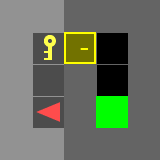

In [38]:
env = DoorKeyEnv5x5()
env.reset()
# obs, reward, done, _ = env.step(1)

{'direction': 2, 'image': array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [2, 5, 0],
         [2, 5, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [2, 5, 0],
         [1, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [2, 5, 0],
         [1, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [2, 5, 0],
         [5, 4, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [2, 5, 0

**Question**: What does `env.reset()` return? What does each item returned mean? What's the shape of the image in the observation? How about the action space? What does each action mean? (Hint: You may find the source code of gym_minigrid helpful.) (10 pts)

**A**: `env.reset()` returns an observation variable, which is a dictionary that contains the current view of the environment (as an image)., agent's facing direction (0: right, 1: down, 2: left, 3: up), a mission description as a string. The current view of the environment has a similar format as a normal 3-channel image (shape: $7\times7\times3$), but it is not an actual image. The values are not pixels. Each value represents a state of the object on that location. Checkout [the source code](https://github.com/maximecb/gym-minigrid/blob/master/gym_minigrid/minigrid.py) for more details. The action space is $7$-dimensional: 0: turn left, 1: turn right, 2: forward, 3: pickup an object, 4: drop an object, 5: activate an object, 6: done completing task.

# Model

In Deep Q-Learning, we estimated the value function for each (state, action) pair. In policy gradients, we will directly learn a policy: i.e, for each state, predict an action!  We call this policy network the *actor*.

Our *actor* will take in as input the `DoorKeyEnv5x5` observation (a 7x7x3 image), and output a categorical distribution over all possible actions.  To choose an action, we will sample from this distribution.  We suggest implementing the actor network to contain a few convolutional layers, followed by a few fully-connected layers.

In addition to the actor network, later questions in the PSET require estimating the value network, called the *critic*.  The critic estimates total future reward, much like DQN in PSET 3, but is notably *on-policy*, meaning it's reward estimates are conditioned on the actor. We will use the critic to reduce variance in the policy gradient estimate. We will get to that soon. 

We have provided you a reference architecture to use for your actor-critic networks. Note that we have separate networks for each that do not share weights, as this has been shown to empirically improve performance. Also note that the policy outputs a `torch.distributions.categorical.Categorical` object.


In [29]:
inp = [
        "FFFSFFFF",
        "FFFFFFFF",
        "HHHHFHFF",
        "FFFFFFHF",
        "FFFFFFFF",
        "FHFFFFHF",
        "FHFFHFHH",
        "FGHFFFFF"
]
agent_loc = 37

h, w = len(inp), len(inp[0])
mapping = {
    'F' : 0,
    'S' : 0,
    'H' : 1,
    'G' : 2,
}
out = np.zeros((w, h, 2))
for i, row in enumerate(inp):
  elems = list(row)
  elems = [mapping[x] for x in elems]
  out[i,:,0] = elems

agent_x = 37 // 8 
agent_y = 37 % 8 
out[agent_x,agent_y,1] = 1


In [79]:
def make_grid(position_agent, grid, device):

  h, w = len(grid), len(grid[0])
  mapping = {
      'F' : 0,
      'S' : 0,
      'H' : 1,
      'G' : 2,
  }
  out = np.zeros((2,w, h))
  for i, row in enumerate(grid):
    elems = list(row)
    elems = [mapping[x] for x in elems]
    out[0,i,:] = elems

  agent_x = position_agent // h 
  agent_y = position_agent % w 
  out[1,agent_x,agent_y] = 1
  out = torch.tensor(out)
  out.to(device)
  return out

In [121]:
#https://discuss.pytorch.org/t/how-can-i-connect-a-new-neural-network-after-a-trained-neural-network-and-optimize-them-together/48293/4
class Critic(nn.Module):
  def __init__(self, num_channels = 3):
    self.num_channels = num_channels
    super().__init__()
    self.conv = nn.Sequential(
                        nn.Conv2d(self.num_channels, 16, (2, 2)),
                        nn.ReLU(),
                        nn.MaxPool2d((2, 2)),
                        nn.Conv2d(16, 32, (2, 2)),
                        nn.ReLU(),
                        nn.Conv2d(32, 64, (2, 2)),
                        nn.ReLU()
                      )
    self.lin = nn.Sequential(
                        nn.Linear(64, 64),
                        nn.Tanh(),
                        nn.Linear(64, 1)
                      )
  def forward(self, obs):
    # obs = torch.tensor(obs)
    if self.num_channels == 3:
      conv_in = obs.transpose(1, 3).transpose(2, 3)
    else:
      conv_in = obs
    y = self.conv(conv_in)
    embedding = y.reshape(y.shape[0], -1)
    if self.num_channels == 2:
      if embedding.shape[0] == 64:
          embedding = torch.transpose(embedding,0,1)
    
    v = self.lin(embedding).squeeze(1)
    
    return v



class ACModel(nn.Module):
    def __init__(self, num_actions, use_critic=False,num_critics=1, env = "DoorKey"):
        super().__init__()
        self.use_critic = use_critic
        self.num_critics = num_critics
        self.num_actions = num_actions

        if env == "DoorKey":
          self.num_channels = 3
        else:
          self.num_channels = 2

        ##### TODO: initialize actor and critic networks #######
        
        # Define actor's model
        self.image_conv_actor = nn.Sequential(
            nn.Conv2d(self.num_channels, 16, (2, 2)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(16, 32, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (2, 2)),
            nn.ReLU()
        )
        self.actor = nn.Sequential(
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, num_actions)
        )

        # Define critic's model
        if self.use_critic:
            critics = nn.ModuleList()
            for i in range(num_critics):
              critics.append(Critic(num_channels = self.num_channels))
            self.critics = critics
        ########################################################

        # Initialize parameters correctly (don't remove this!)
        self.apply(init_params)

    def forward(self, obs):
        # obs = torch.tensor(obs)
        
        if self.num_channels == 3:
          conv_in = obs.transpose(1, 3).transpose(2, 3) # reshape into expected order
        else:
          conv_in = obs
        dist, value = None, None
        ##### TODO: produce Categorical action distribtuion and critic value output #####
        ##### if self.use_critic is false, return all zeros for value ###################
        x = self.image_conv_actor(conv_in)
        embedding = x.reshape(x.shape[0], -1)
        if self.num_channels == 2:
          if embedding.shape[0] == 64:
            embedding = torch.transpose(embedding,0,1)

        print(embedding.shape)
        x = self.actor(embedding)
        dist = Categorical(logits=F.log_softmax(x, dim=1))

        if self.use_critic:
            # y = self.image_conv_critic(conv_in)
            # embedding = y.reshape(y.shape[0], -1)

            # value = self.critic(embedding).squeeze(1)
            value = torch.zeros((x.shape[0], self.num_critics), device=x.device)
            for i, critic in enumerate(self.critics):
              value[:,i] = critic(obs)
        else:
            value = torch.zeros((x.shape[0], 1), device=x.device)
        ##################################################################################

        return dist, value

# Model Evaluation

The following code runs the actor critic model `acmodel` for one episode, and returns a dictionary with all the relevant information from the rollout.  It relies on placeholders below for `compute_advantage_gae` and `compute_discounted_return`: you can ignore these for now, and just evaluate through to the next section.  However, it might be useful to review this code just to make sure you understand what's going on.

In [40]:
def compute_advantage_gae(values, rewards, T, gae_lambda, discount, pbar, uncertainty_aware = True):
    vars = values.var(dim=1)
    values = values.mean(dim=1)
    advantages = torch.zeros_like(values)

    #### TODO: populate GAE in advantages over T timesteps (10 pts) ############
    for i in reversed(range(T)):
        next_value = values[i+1]
        next_advantage = advantages[i+1]

        delta = rewards[i] + args.discount * next_value  - values[i]
        advantages[i] = delta + args.discount * args.gae_lambda * next_advantage 
    ############################################################################
    #print("OLD ADV: ", advantages)
    if uncertainty_aware:
      advantages = advantages * torch.exp(1/math.log(pbar+2) * vars - vars)
    #print("NEW ADV: ", advantages)
    return advantages[:T]

In [41]:
def compute_discounted_return(rewards, discount, device=None):
    returns = torch.zeros(*rewards.shape, device=device)

    #### TODO: populate discounted reward trajectory (10 pts) ############
    R = 0
    for t in reversed(range((rewards.shape[0]))):
        R = rewards[t] + discount * R
        returns[t] = R
    ######################################################################

    return returns

In [115]:
def collect_experiences(env, acmodel, args, pbar, device=None, environment = "DoorKey"):
    """Collects rollouts and computes advantages.
    Returns
    -------
    exps : dict
        Contains actions, rewards, advantages etc as attributes.
        Each attribute, e.g. `exps['reward']` has a shape
        (self.num_frames, ...).
    logs : dict
        Useful stats about the training process, including the average
        reward, policy loss, value loss, etc.
    """


    MAX_FRAMES_PER_EP = 300
    shape = (MAX_FRAMES_PER_EP, )

    actions = torch.zeros(*shape, device=device, dtype=torch.int)
    values = torch.zeros((MAX_FRAMES_PER_EP, acmodel.num_critics), device=device)
    rewards = torch.zeros(*shape, device=device)
    log_probs = torch.zeros(*shape, device=device)
    obss = [None]*MAX_FRAMES_PER_EP

    obs = env.reset()
    total_return = 0

    T = 0

    while True:
        # Do one agent-environment interaction
        if environment == "DoorKey":
          preprocessed_obs = preprocess_obss(obs, device=device)
        else:
          preprocessed_obs = make_grid(obs, args.grid, device = device)
          preprocessed_obs = preprocessed_obs.float().cuda()
        with torch.no_grad():
            dist, value = acmodel(preprocessed_obs)
        action = dist.sample()[0]


        obss[T] = obs
        obs, reward, done, _ = env.step(action.item())


        # Update experiences values
        actions[T] = action
        values[T] = value
        rewards[T] = reward
        log_probs[T] = dist.log_prob(action)


        total_return += reward
        T += 1

        if done:
            break

    discounted_reward = compute_discounted_return(rewards[:T], args.discount, device)
    if acmodel.num_critics == 1:
      advantage_gae=compute_advantage_gae(values, rewards, T, args.gae_lambda, args.discount, pbar = pbar, uncertainty_aware = False)
    else:
      advantage_gae=compute_advantage_gae(values, rewards, T, args.gae_lambda, args.discount, pbar = pbar, uncertainty_aware = True)
    
    if args.env == "DoorKey":
      observations = preprocess_obss([
            obss[i]
            for i in range(T)
        ], device=device)
    else:
      observations = torch.zeros((T, 2, 8, 8)).float().cuda()
      for i in range(T):
        observations[i,:,:,:] =  make_grid(obss[i], args.grid, device = device).float().cuda()

    exps = dict(
        obs = observations,
        action = actions[:T],
        value  = values[:T],
        reward = rewards[:T],
        advantage = discounted_reward-values[:T,:].mean(dim=1),
        log_prob = log_probs[:T],
        discounted_reward = discounted_reward,
        advantage_gae=advantage_gae
    )

    logs = {
        "return_per_episode": total_return,
        "num_frames": T
    }

    return exps, logs

# REINFORCE

Now comes the fun part!  Using the `collect_experiences` function and `ACModel`, we will implement vanilla policy gradients.  The following function takes in an `optimizer`, `ACModel`, batch of experience `sb`, and some arguments `args` (see `Config` in setup for fields and default values), and should perform a policy gradients parameter update using the observed experience.

Fill in todos below to implement vanilla policy gradients (20 pts).

In [13]:
def update_parameters_reinforce(optimizer, acmodel, sb, args):
    def _compute_policy_loss(logps, returns):
        policy_loss = torch.tensor(0)

        #### TODO: complete policy loss (10 pts) ###
        policy_loss = -(logps * returns).mean()
        ############################################

        return policy_loss


    logps, reward = None, None
    
    ### TODO: compute logps and reward from acmodel, sb['obs'], sb['action'], and sb['reward'] ###
    ### If args.use_discounted_reward is True, use sb['discounted_reward'] instead. ##############
    ### (10 pts) #########################################
    dist, _= acmodel(sb['obs'])           
    logps = dist.log_prob(sb['action']) 

    # NOTE: simply setting rewards = sb['reward'] is also sufficient for full credit due to 
    # some abiguities on our part
    if args.use_discounted_reward:
        reward = sb['discounted_reward']
    else:
        rewards = sb['reward']
        rewards_len = rewards.size()[0]
        returns = np.zeros((rewards_len)).astype(np.float32)
        R = 0
        for t in reversed(range((rewards_len))):
            R = rewards[t] + R
            returns[t] = R
        reward = torch.from_numpy(returns).to(sb['reward'].device)
    ##############################################################################################

    policy_loss = _compute_policy_loss(logps, reward)
    update_policy_loss = policy_loss.item()

    # Update actor-critic
    optimizer.zero_grad()
    policy_loss.backward()
    
    # Perform gradient clipping for stability
    for p in acmodel.parameters():
        if p.grad is None:
            print("Make sure you're not instantiating any critic variables when the critic is not used")
    update_grad_norm = sum(p.grad.data.norm(2) ** 2 for p in acmodel.parameters()) ** 0.5
    torch.nn.utils.clip_grad_norm_(acmodel.parameters(), args.max_grad_norm)
    optimizer.step()

    # Log some values
    logs = {
        "policy_loss": update_policy_loss,
        "grad_norm": update_grad_norm
    }

    return logs

Now, let's try to run our implementation.  The following experiment harness is written for you, and will run sequential episodes of policy gradients until `args.max_episodes` timesteps are exceeded or the rolling average reward (over the last 100 episodes is greater than `args.score_threshold`. It is expected to get highly variable results, and we'll visualize some of this variability at the end.

The method accepts as arguments a `Config` object `args`, and a `parameter_update` method (such as `update_parameters_reinforce`).

In [57]:
# def run_experiment(args, parameter_update):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     env = DoorKeyEnv5x5()

#     acmodel = ACModel(env.action_space.n, use_critic=args.use_critic, num_critics = args.num_critics)
#     acmodel.to(device)

#     is_solved = False
    
#     SMOOTH_REWARD_WINDOW = 50

#     pd_logs, rewards = [], [0]*SMOOTH_REWARD_WINDOW
#     actor_params = itertools.islice(acmodel.parameters(), 5)
#     #critics_params = itertools.islice(acmodel.parameters(), 5, 5*(acmodel.num_critics+1), 1)
#     optimizer_actor = torch.optim.Adam(actor_params, lr=args.lr)
#     #optimizer_critic = torch.optim.Adam(critics_params, lr=args.lr)
#     num_frames = 0

#     pbar = tqdm(range(args.max_episodes))
#     for update in pbar:
#         #exps, logs1 = collect_experiences(env, acmodel, args, device)
#         exp_batch = [collect_experiences(env, acmodel, args, pbar = update, device) for _ in range(args.batch_size)]
#         for i, (exp, logs) in enumerate(exp_batch):
#           #update policy on exp 
#           logs_actor = parameter_update(optimizer_actor, acmodel, exp, args, target_params = "actor")
#           #log data
#           rewards.append(logs["return_per_episode"])
#           num_frames += logs["num_frames"]
#           smooth_reward = np.mean(rewards[-SMOOTH_REWARD_WINDOW:])

#           data = {'episode':update*args.batch_size + i, 'num_frames':num_frames, 'smooth_reward':smooth_reward,
#                 'reward':logs["return_per_episode"], 'policy_loss':logs_actor["policy_loss"]}
#           if args.use_critic:
#             data['value_loss'] = logs_actor["value_loss"]
#           pd_logs.append(data)
#           pbar.set_postfix(data)
#           # Early terminate
#           if smooth_reward >= args.score_threshold:
#               is_solved = True
#               break

#         if is_solved: break
#         for b in range(acmodel.num_critics):
#           boot_D = [random.choice(exp_batch) for _ in exp_batch]
#           for exp, logs in boot_D:
#             critic_params = acmodel.critics[b].parameters()
#             optimizer_critic = torch.optim.Adam(critic_params, lr=args.lr)
#             logs_critic = parameter_update(optimizer_critic, acmodel, exp, args, target_params = "critic",critic_index = b)

#         #logs = {**exp_batch[-1][1], **logs_actor}

#         #num_frames += logs["num_frames"]
        
#         #rewards.append(logs["return_per_episode"])
        

#         # data = {'episode':update*batch_size, 'num_frames':num_frames, 'smooth_reward':smooth_reward,
#         #         'reward':logs["return_per_episode"], 'policy_loss':logs["policy_loss"]}
        
#         # if args.use_critic:
#         #     data['value_loss'] = logs["value_loss"]

#         # pd_logs.append(data)

#         # pbar.set_postfix(data)


#     if is_solved:
#         print('Solved!')
    
#     return pd.DataFrame(pd_logs).set_index('episode')


In [80]:
def run_experiment(args, parameter_update):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if args.env == "FrozenLake":
      env = gym.make('Stochastic-8x8-FrozenLake-v0')
    else:
      assert(args.env == "DoorKey")
      env = DoorKeyEnv5x5()

    acmodel = ACModel(env.action_space.n, env = args.env, use_critic=args.use_critic, num_critics = args.num_critics)
    acmodel.to(device)

    is_solved = False
    
    SMOOTH_REWARD_WINDOW = 50

    pd_logs, rewards = [], [0]*SMOOTH_REWARD_WINDOW
    actor_params = acmodel.parameters()
    optimizer_actor = torch.optim.Adam(actor_params, lr=args.lr)
    num_frames = 0

    pbar = tqdm(range(args.max_episodes))
    for update in pbar:
        exp, logs = collect_experiences(env, acmodel, args, update, device, environment = args.env)
        logs_actor = parameter_update(optimizer_actor, acmodel, exp, args, target_params = "actor")
        #log data
        rewards.append(logs["return_per_episode"])
        num_frames += logs["num_frames"]
        smooth_reward = np.mean(rewards[-SMOOTH_REWARD_WINDOW:])
        data = {'episode':update, 'num_frames':num_frames, 'smooth_reward':smooth_reward,
                'reward':logs["return_per_episode"], 'policy_loss':logs_actor["policy_loss"]}
          
        if args.use_critic:
          data['value_loss'] = logs_actor["value_loss"]
        pd_logs.append(data)
        pbar.set_postfix(data)
        # Early terminate
        if smooth_reward >= args.score_threshold:
            is_solved = True
            break
        if is_solved: break
        for b in range(acmodel.num_critics):
          if (np.random.random() <= 0.67) or (acmodel.num_critics == 1):
            critic_params = acmodel.critics[b].parameters()
            optimizer_critic = torch.optim.Adam(critic_params, lr=args.lr)
            logs_critic = parameter_update(optimizer_critic, acmodel, exp, args, target_params = "critic",critic_index = b)

    if is_solved:
        print('Solved!')
    
    return pd.DataFrame(pd_logs).set_index('episode')


# Proximal Policy Optimization

Our work is not yet done!  There are some surprisingly powerful additional tweaks we can make to our GAE implementation to further improve performance.

The current standard in policy gradients today is [Proximal Policy Optimization](https://arxiv.org/abs/1707.06347), which improves on GAE by taking multiply policy update steps per minibatch, enabled by policy update clipping (this is a specific variant called *PPO-Clip*).  This leads to greater sample efficiency, as larger steps can be taken from the same data samples.

We've implemented most of PPO for you: all that's left for you are the policy and value loss computations (note that you'll have to evaluate the `acmodel` each time you compute them).  Note that for the policy loss, we also ask that you return the approximate KL divergence between the new and old action distributions notated as `approx_kl`; this is used to facilitate an early stopping condition in policy updates. This [blog post](http://joschu.net/blog/kl-approx.html) shares a simple formula for approximating KL divergence that you can use.

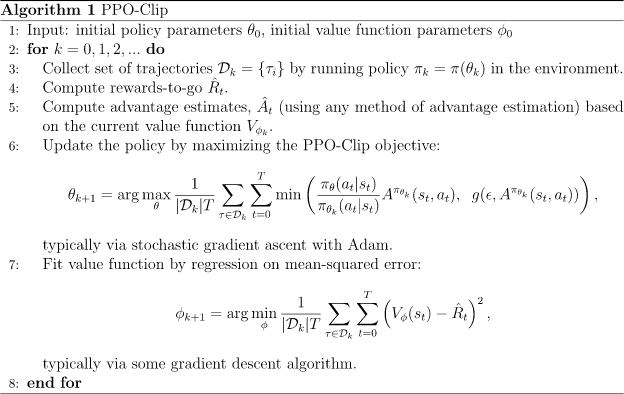 

where 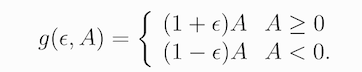

A commonly used technique is to add entropy regularization for policy gradient methods as shown in equation 2 of [this paper](https://arxiv.org/pdf/1611.01626.pdf), and there is some discussion of entropy regularization in this [reference tutorial](https://arxiv.org/pdf/1805.00909.pdf). You should compute the policy loss as defined above and also add in an entropy term for the updated policy (note that we've provided to you an entropy coefficient in `args.entropy_coef`).

In [44]:
def update_parameters_ppo(optimizer, acmodel, sb, args, target_params,critic_index = 1):
    def _compute_policy_loss_ppo(obs, old_logp, actions, advantages):
        policy_loss, approx_kl = 0, 0

        ### TODO: implement PPO policy loss computation (30 pts).  #######
        # approx kl 5
        # a few ways to approximate - 
        #  k1 = -logr
        #  k2 = logr ** 2 / 2
        #  k3 = (logr.exp() - 1) - logr
        #  or p * log(p/q)
        # entropy term 5 
        # ratio clamping/clipping 10
        # remaining correctness 10
        new_dist, _ = acmodel(obs)
        new_logp = new_dist.log_prob(actions)

        ratio = torch.exp(new_logp - old_logp)
        clip_adv = torch.clamp(ratio, 1-args.clip_ratio, 1+args.clip_ratio) * advantages

        entropy_loss = -args.entropy_coef * new_dist.entropy().mean()
        policy_loss = -(torch.min(ratio*advantages, clip_adv)).mean() 
        policy_loss += entropy_loss

        approx_kl = 0.5 * ((old_logp - new_logp).mean().item()) ** 2

        ##################################################################
        
        return policy_loss, approx_kl
    
    def _compute_value_loss(obs, returns, critic_index):
        ### TODO: implement PPO value loss computation (10 pts) ##########
        returns = returns.repeat(acmodel.num_critics,1).T
        _, values = acmodel(obs)
        value_loss = (values[:,critic_index] - returns[:,critic_index]).pow(2).mean()
        ##################################################################

        return value_loss


    dist, _ = acmodel(sb['obs'])            
    old_logp = dist.log_prob(sb['action']).detach()
    
    advantage = sb['advantage_gae'] if args.use_gae else sb['advantage']

    policy_loss, _ = _compute_policy_loss_ppo(sb['obs'], old_logp, sb['action'], advantage)
    #value_loss = _compute_value_loss(sb['obs'], sb['discounted_reward'], critic_index = critic_index)

    for i in range(args.train_ac_iters):
        optimizer.zero_grad()
        loss_pi, approx_kl = _compute_policy_loss_ppo(sb['obs'], old_logp, sb['action'], advantage)
        if target_params == "actor": 
          loss = loss_pi
        else:
          loss_v = _compute_value_loss(sb['obs'], sb['discounted_reward'],critic_index = critic_index)
          loss = loss_v

        if approx_kl > 1.5 * args.target_kl:
            break
        
        loss.backward(retain_graph=True)
        optimizer.step()
    
    update_policy_loss = policy_loss.item()
    #update_value_loss = value_loss.item()

    logs = {
        "policy_loss": update_policy_loss,
        "value_loss": 69,
    }

    return logs

In [ ]:
args = Config(use_critic=True, use_gae=True)
args.num_critics = 10
args.env = "FrozenLake"
args.grid = [
            "FFFSFFFF",
            "FFFFFFFF",
            "HHHHFHFF",
            "FFFFFFHF",
            "FFFFFFFF",
            "FHFFFFHF",
            "FHFFHFHH",
            "FGHFFFFF"
            ]
            
df_ppo = run_experiment(args, update_parameters_ppo)

df_ppo.plot(x='num_frames', y=['reward', 'smooth_reward'])

  0%|          | 0/2000 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Size([7, 64])
torch.Siz

In [ ]:
num_seeds = 5
df_master = pd.DataFrame()
for i in range(num_seeds):
  #Only 1 critic (Vanilla PPO)
  args = Config(use_critic=True, use_gae=True)
  args.num_critics = 1
  # args.batch_size = 4
  df_ppo = run_experiment(args, update_parameters_ppo)
  df_ppo['Algorithm'] = 'PPO'
  df_ppo['Seed'] = i
  df_ppo['episode'] = np.arange(df_ppo.shape[0])
  df_master = pd.concat((df_master,df_ppo),ignore_index=True)
  #10 critics
  args = Config(use_critic=True, use_gae=True)
  args.num_critics = 10
  # args.batch_size = 4
  df_var_ppo = run_experiment(args, update_parameters_ppo)
  df_var_ppo['Algorithm'] = 'Var PPO'
  df_var_ppo['Seed'] = i
  df_var_ppo['episode'] = np.arange(df_var_ppo.shape[0])
  df_master = pd.concat((df_master,df_var_ppo),ignore_index=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
sns.lineplot(data=df_master, x="episode", y="smooth_reward", hue="Algorithm",estimator="mean").set(
    title='Comparison of Various Model-Free RL Algorithms on DoorKey')

# Fancy Plots

If you've gotten to this point, congrats: you've succesfully implemented REINFORCE, VPG, GAE, and PPO!  While we've been able to anecdotally compare their performance, we don't have any sense of *scientific rigor*.  Notably, given the variance you've likely seen between runs of these models, a single run may not reflect how strong a model really is.

For this problem, train each of these 4 methods using multiple seeds (at least 5, but more if you feel you need them).  Then, generate a high quality reward curve plot comparing each algorithm.  The plot should be clean and legible, and clearly demonstrate the performance and variance of each of the approaches.  As an example, see Figure 3 of the PPO paper (although we're only evaluating on a single environment).

Be creative and make something pretty: it matters for good science!

**Note:** you should leave a few hours for this to run.

In [ ]:
### TODO: generate your master comparison plot (30 pts)
import time

start = time.time()

'''
REINFORCE
'''
end = time.time()
print(f"[{end - start}] starting reinforce experiments")
args = Config(score_threshold=1.1)
df_reinforce_1 = run_experiment(args, update_parameters_reinforce)
df_reinforce_2 = run_experiment(args, update_parameters_reinforce)
end = time.time()
print(f"[{end - start}] finished 2 reinforce experiments")
df_reinforce_3 = run_experiment(args, update_parameters_reinforce)
df_reinforce_4 = run_experiment(args, update_parameters_reinforce)
df_reinforce_5 = run_experiment(args, update_parameters_reinforce)

'''
REINFORCE with baseline
'''
end = time.time()
print(f"[{end - start}] starting reinforce with baseline experiments")
args = Config(use_critic=True, score_threshold=1.1)
df_baseline_1 = run_experiment(args, update_parameters_with_baseline)
df_baseline_2 = run_experiment(args, update_parameters_with_baseline)
print(f"[{end - start}] finished 2 reinforce with baseline experiments")
df_baseline_3 = run_experiment(args, update_parameters_with_baseline)
df_baseline_4 = run_experiment(args, update_parameters_with_baseline)
df_baseline_5 = run_experiment(args, update_parameters_with_baseline)

'''
REINFORCE with GAE baseline
'''
end = time.time()
print(f"[{end - start}] starting reinforce with gae baseline experiments")
args = Config(use_critic=True, use_gae=True, score_threshold=1.1)
df_gae_1 = run_experiment(args, update_parameters_with_baseline)
df_gae_2 = run_experiment(args, update_parameters_with_baseline)
print(f"[{end - start}] finished 2 reinforce with gae baseline experiments")
df_gae_3 = run_experiment(args, update_parameters_with_baseline)
df_gae_4 = run_experiment(args, update_parameters_with_baseline)
df_gae_5 = run_experiment(args, update_parameters_with_baseline)

'''
PPO
'''
end = time.time()
print(f"[{end - start}] starting ppo experiments")
args = Config(use_critic=True, use_gae=True, score_threshold=1.1)
df_ppo_1 = run_experiment(args, update_parameters_ppo)
df_ppo_2 = run_experiment(args, update_parameters_ppo)
print(f"[{end - start}] finished 2 ppo experiments")
df_ppo_3 = run_experiment(args, update_parameters_ppo)
df_ppo_4 = run_experiment(args, update_parameters_ppo)
df_ppo_5 = run_experiment(args, update_parameters_ppo)

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

save_path = '/content/drive/My Drive/Public/'
save = False
load = True
if save:
  '''
  REINFORCE 
  '''
  df_reinforce_1.to_csv(f'{save_path}1_reinforce_1.csv')
  df_reinforce_2.to_csv(f'{save_path}1_reinforce_2.csv')
  df_reinforce_3.to_csv(f'{save_path}1_reinforce_3.csv')
  df_reinforce_4.to_csv(f'{save_path}1_reinforce_4.csv')
  df_reinforce_5.to_csv(f'{save_path}1_reinforce_5.csv')

  '''
  REINFORCE with baseline
  '''
  df_baseline_1.to_csv(f'{save_path}2_baseline_1.csv')
  df_baseline_2.to_csv(f'{save_path}2_baseline_2.csv')
  df_baseline_3.to_csv(f'{save_path}2_baseline_3.csv')
  df_baseline_4.to_csv(f'{save_path}2_baseline_4.csv')
  df_baseline_5.to_csv(f'{save_path}2_baseline_5.csv')

  '''
  REINFORCE with GAE baseline
  '''
  df_gae_1.to_csv(f'{save_path}3_gae_1.csv')
  df_gae_2.to_csv(f'{save_path}3_gae_2.csv')
  df_gae_3.to_csv(f'{save_path}3_gae_3.csv')
  df_gae_4.to_csv(f'{save_path}3_gae_4.csv')
  df_gae_5.to_csv(f'{save_path}3_gae_5.csv')

  '''
  PPO
  '''
  df_ppo_1.to_csv(f'{save_path}4_ppo_1.csv')
  df_ppo_2.to_csv(f'{save_path}4_ppo_2.csv')
  df_ppo_3.to_csv(f'{save_path}4_ppo_3.csv')
  df_ppo_4.to_csv(f'{save_path}4_ppo_4.csv')
  df_ppo_5.to_csv(f'{save_path}4_ppo_5.csv')
elif load:
  '''
  REINFORCE 
  '''
  pd.DataFrame
  df_reinforce_1 = pd.read_csv(f'{save_path}1_reinforce_1.csv')
  df_reinforce_2 = pd.read_csv(f'{save_path}1_reinforce_2.csv')
  df_reinforce_3 = pd.read_csv(f'{save_path}1_reinforce_3.csv')
  df_reinforce_4 = pd.read_csv(f'{save_path}1_reinforce_4.csv')
  df_reinforce_5 = pd.read_csv(f'{save_path}1_reinforce_5.csv')

  '''
  REINFORCE with baseline
  '''
  df_baseline_1 = pd.read_csv(f'{save_path}2_baseline_1.csv')
  df_baseline_2 = pd.read_csv(f'{save_path}2_baseline_2.csv')
  df_baseline_3 = pd.read_csv(f'{save_path}2_baseline_3.csv')
  df_baseline_4 = pd.read_csv(f'{save_path}2_baseline_4.csv')
  df_baseline_5 = pd.read_csv(f'{save_path}2_baseline_5.csv')

  '''
  REINFORCE with GAE baseline
  '''
  df_gae_1 = pd.read_csv(f'{save_path}3_gae_1.csv')
  df_gae_2 = pd.read_csv(f'{save_path}3_gae_2.csv')
  df_gae_3 = pd.read_csv(f'{save_path}3_gae_3.csv')
  df_gae_4 = pd.read_csv(f'{save_path}3_gae_4.csv')
  df_gae_5 = pd.read_csv(f'{save_path}3_gae_5.csv')

  '''
  PPO
  '''
  df_ppo_1 = pd.read_csv(f'{save_path}4_ppo_1.csv')
  df_ppo_2 = pd.read_csv(f'{save_path}4_ppo_2.csv')
  df_ppo_3 = pd.read_csv(f'{save_path}4_ppo_3.csv')
  df_ppo_4 = pd.read_csv(f'{save_path}4_ppo_4.csv')
  df_ppo_5 = pd.read_csv(f'{save_path}4_ppo_5.csv')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
episodes = [i for i in range(len(df_ppo_1))]
ppo_smooth_reward = [df['smooth_reward'] for df in [df_ppo_1, df_ppo_2, df_ppo_3, df_ppo_4, df_ppo_5]]
reinforce_gae_smooth_reward = [df['smooth_reward'] for df in [df_gae_1, df_gae_2, df_gae_3, df_gae_4, df_gae_5]]
reinforce_baseline_smooth_reward = [df['smooth_reward'] for df in [df_baseline_1, df_baseline_2, df_baseline_3, df_baseline_4, df_baseline_5]]
reinforce_smooth_reward = [df['smooth_reward'] for df in [df_reinforce_1, df_reinforce_2, df_reinforce_3, df_reinforce_4, df_reinforce_5]]

ppo_np = np.vstack(ppo_smooth_reward)
reinforce_gae_np = np.vstack(reinforce_gae_smooth_reward)
reinforce_baseline_np = np.vstack(reinforce_baseline_smooth_reward)
reinforce_np = np.vstack(reinforce_smooth_reward)

ppo_mean = np.mean(ppo_np, axis=0)
ppo_std = np.std(ppo_np, axis=0)
gae_mean = np.mean(reinforce_gae_np, axis=0)
gae_std = np.std(reinforce_gae_np, axis=0)
baseline_mean = np.mean(reinforce_baseline_np, axis=0)
baseline_std = np.std(reinforce_baseline_np, axis=0)
reinforce_mean = np.mean(reinforce_np, axis=0)
reinforce_std = np.std(reinforce_np, axis=0)


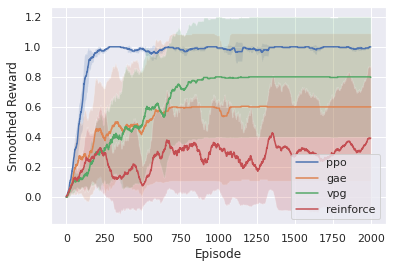

In [ ]:
import seaborn as sns
sns.set()

plt.plot(episodes, ppo_mean, label='ppo')
plt.fill_between(episodes, ppo_mean - ppo_std, ppo_mean + ppo_std, alpha=0.2)

plt.plot(episodes, gae_mean, label='gae')
plt.fill_between(episodes, gae_mean - gae_std, gae_mean + gae_std, alpha=0.2)

plt.plot(episodes, baseline_mean, label='vpg')
plt.fill_between(episodes, baseline_mean - baseline_std, baseline_mean + baseline_std, alpha=0.2)

plt.plot(episodes, reinforce_mean, label='reinforce')
plt.fill_between(episodes, reinforce_mean - reinforce_std, reinforce_mean + reinforce_std, alpha=0.2)

plt.xlabel('Episode')
plt.ylabel('Smoothed Reward')
plt.legend()
plt.show()


# Survey (bonus points, 10 pts)
Please fill out [this anonymous survey](https://docs.google.com/forms/d/e/1FAIpQLSd_ZbQryW1NqcLHg8I0zbe4_WDyQ_MNCsJRg3GxBgk1-8cr2w/viewform?usp=sf_link) and enter the code below to receive credit. Thanks!

**Code:** variance_reduction